## CHATBOT WITH LANGGRAPH

### Here is a phase one in this phase one define some common notation

##### Here is my model

In [ ]:
'''from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")'''
GROQ_API_KEY=''
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",  # or "llama3-70b-8192", "gemma-7b-it"
    groq_api_key=GROQ_API_KEY
)

In [67]:
llm.invoke("hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010070654, 'prompt_time': 0.017597511, 'queue_time': 0.202287524, 'total_time': 0.027668165}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3e3238c0-1e4e-4435-9e2a-b9b40d0affd6-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [68]:
llm.invoke("hello").content

'Hello. How can I assist you today?'

##### This is all the import statement

In [69]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

##### Here is a my call model Function

https://github.com/langchain-ai/langgraph/tree/main/libs/langgraph/langgraph/graph

In [70]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

#### Here is my workflow

In [71]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

#### Here is my visualization

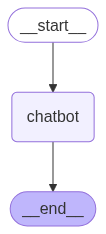

In [72]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

#### Here i am invoking the Graph

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [73]:
input={"messages":["hi, my name is sunny"]}

In [74]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is sunny', additional_kwargs={}, response_metadata={}, id='263002f3-66d5-438f-8985-2fa86da9a6ca'),
  AIMessage(content="Hi Sunny, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 41, 'total_tokens': 67, 'completion_time': 0.043262512, 'prompt_time': 0.011062292, 'queue_time': 0.200442797, 'total_time': 0.054324804}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2f5226eb-8ba6-4ed6-b35e-6fb244f5c6ac-0', usage_metadata={'input_tokens': 41, 'output_tokens': 26, 'total_tokens': 67})]}

#### Here i am streaming the output

In [75]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hi Sunny, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 41, 'total_tokens': 67, 'completion_time': 0.036176084, 'prompt_time': 0.015809328, 'queue_time': 0.200545959, 'total_time': 0.051985412}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a5dd974a-093b-4346-bfc6-93e1cd4a4431-0', usage_metadata={'input_tokens': 41, 'output_tokens': 26, 'total_tokens': 67})]}




## starting phase2 from here with tool

##### Lets first add the custom tool

In [76]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [77]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [78]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [80]:
tools=[search]

In [79]:
tools

[StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000028348E53D00>)]

In [81]:
tool_node=ToolNode(tools)

In [82]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002834AEACD30>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [83]:
llm_with_tool=llm.bind_tools(tools)

In [84]:
llm_with_tool.invoke("hi")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7zpzbcmhd', 'function': {'arguments': '{"query":"hi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 209, 'total_tokens': 222, 'completion_time': 0.031200001, 'prompt_time': 0.023458269, 'queue_time': 0.205866781, 'total_time': 0.05465827}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a1957bb4-767b-4796-9e99-d20e947fc25a-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi'}, 'id': '7zpzbcmhd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 13, 'total_tokens': 222})

##### Here is a my call model binding with tool

In [85]:
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]

In [86]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [87]:
response=call_model({"messages": ["hi how are you?"]})

In [88]:
response

{'messages': [AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.061912273, 'prompt_time': 0.024909102, 'queue_time': 0.20206212, 'total_time': 0.086821375}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9466995a-73c6-49f8-bfd2-1ca6e405e0c9-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

AIMessage(content='I am doing well, thank you. How can I help you?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 941, 'total_tokens': 957, 'completion_time': 0.029090909, 'prompt_time': 0.031196443, 'queue_time': 0.0032329660000000003, 'total_time': 0.060287352}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-1db8fb5d-a8fd-4f85-8091-c2662bc18c22-0', usage_metadata={'input_tokens': 941, 'output_tokens': 16, 'total_tokens': 957})

##### Show the above output with the json viewer

In [89]:
messages = response['messages']

In [90]:
last_message=messages[-1]

In [91]:
last_message.tool_calls

[]

In [92]:
response=call_model({"messages": ["what is a weather in India?"]})

BadRequestError: Error code: 400 - {'error': {'message': 'tool call validation failed: attempted to call tool \'search{"query": "India weather"}\' which was not in request.tools', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=search{"query": "India weather"}></function>'}}

In [93]:
messages = response['messages']

In [94]:
last_message=messages[-1]

In [95]:
last_message.tool_calls

[]

#### Here is my Router Function

In [96]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

### lets design the workflow now

In [97]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

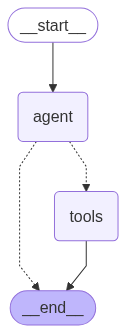

In [98]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [99]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='1e5956e4-7e5d-4db0-b63c-48b2b1481e2a'),
  AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.058521395, 'prompt_time': 0.018155572, 'queue_time': 0.20414126, 'total_time': 0.076676967}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--dfcd0358-2616-41e4-9307-2293a46c320e-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

In [100]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='f22a2c3f-d544-49e3-a349-620dcee3e5e2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'eqpd963tc', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.040626146, 'prompt_time': 0.024601947, 'queue_time': 0.198944023, 'total_time': 0.065228093}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--201b70b5-1f78-4637-86d3-d16f63887a54-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'eqpd963tc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229}),
  ToolMessage(content="It's 60 degrees a

In [101]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8vpwtfcdy', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.046781899, 'prompt_time': 0.024762723, 'queue_time': 0.198662725, 'total_time': 0.071544622}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c46a21a7-cbe2-499d-8574-2fa83fdada18-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': '8vpwtfcdy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='233b3efa-9d78-4da3-aae5-a2

#### Lets create a loop now

In [102]:
workflow.add_edge("tools", 'agent')


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [103]:
app = workflow.compile()

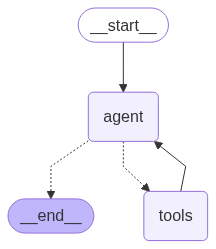

In [104]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [106]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '54txnmz7x', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.048436057, 'prompt_time': 0.024845731, 'queue_time': 0.202869064, 'total_time': 0.073281788}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6f5f3236-e54e-4780-b136-0a6630c962ca-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': '54txnmz7x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='f0010f2e-e93e-46c2-b546-0a

#### Strating Phase 3 from here with memory and checkpointing

In [107]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [108]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

app3 = workflow3.compile(checkpointer = memory)

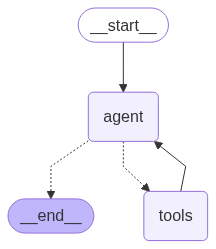

In [65]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [109]:
config = {"configurable": {"thread_id": "1"}}

In [110]:
events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

In [92]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================

Nice to meet you, Sunny! What can I do for you today?


In [111]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [112]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================
Tool Calls:
  search (mpfz4dteb)
 Call ID: mpfz4dteb
  Args:
    query: user name
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  search (h0432cgma)
 Call ID: h0432cgma
  Args:
    query: user name
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and I don't retain any information from previous conversations. If you'd like to share your name, I'd be happy to chat with you.


In [113]:
config

{'configurable': {'thread_id': '1'}}

In [114]:
memory.get(config)

{'v': 4,
 'ts': '2025-09-15T07:11:00.653485+00:00',
 'id': '1f092032-24d5-60c5-8005-3c5022acdbc8',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.9688241782006375',
  'messages': '00000000000000000000000000000007.0.8999451005322785',
  'branch:to:agent': '00000000000000000000000000000007.0.8999451005322785',
  'branch:to:tools': '00000000000000000000000000000006.0.9134906357853775'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.3202200514804806'},
  'agent': {'branch:to:agent': '00000000000000000000000000000006.0.9134906357853775'},
  'tools': {'branch:to:tools': '00000000000000000000000000000005.0.6522838354619467'}},
 'channel_values': {'messages': [HumanMessage(content='can you tell me what was my name?', additional_kwargs={}, response_metadata={}, id='7804a474-77a5-4384-a2eb-d083db018694'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mpfz4dteb', 'function': {'arguments': '{"query"

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

ImportError: cannot import name 'TavilySearch' from 'langchain_community.tools.tavily_search' (c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_community\tools\tavily_search\__init__.py)